### Import relevant libraries

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

### Load training and testing data

In [6]:
%cd /content/drive/MyDrive/python_for_business_and_finance/RNN_for_google_stock_price_prediction

train = pd.read_csv("Google_Stock_Price_Train.csv", parse_dates = ['Date'])
test = pd.read_csv("Google_Stock_Price_Test.csv", parse_dates = ['Date'])

train.head()

/content/drive/MyDrive/python_for_business_and_finance/RNN_for_google_stock_price_prediction


,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
1,2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2,2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
3,2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
4,2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


### Plot Google open stock price from 2012 to 2016

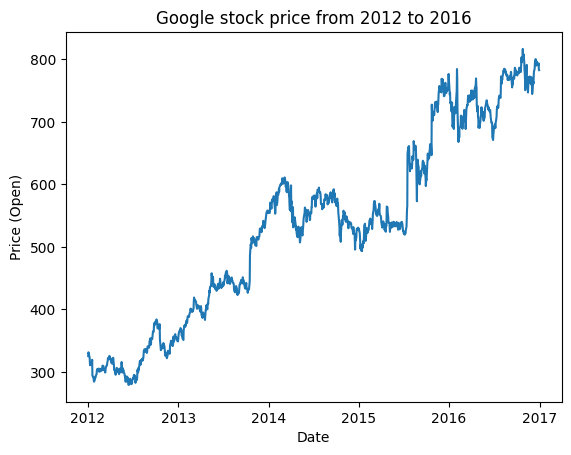

In [9]:
plt.plot(train['Date'], train['Open'])
plt.title("Google stock price from 2012 to 2016")
plt.xlabel("Date")
plt.ylabel("Price (Open)")
plt.show()

### Data preprocessing

In [16]:
# Select open price from training set
open_train = train['Open'].values

# Normalize the data
scaler = MinMaxScaler()
scaler.fit(open_train.reshape(-1, 1))
open_train_scaled = scaler.transform(open_train.reshape(-1, 1)).flatten()

print(open_train_scaled[:5])

[0.08581368 0.09701243 0.09433366 0.09156187 0.07984225]


In [17]:
# Create variables X and y. 60 days od price data ---> predicts next day price
X_train = []
y_train = []

for i in range(60, len(train)):
  X_train.append(open_train_scaled[i-60:i])
  y_train.append(open_train_scaled[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape, y_train.shape)

(1198, 60) (1198,)


In [19]:
# Reshaping to match required input shape for RNN (see Keras documentation) (batch_size, timesteps, input_dim)
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1)) # only one batch of data

### Building RNN form LSTM layers

In [20]:
# Add input layer
inputs = tf.keras.layers.Input(shape = (X_train.shape[1], X_train.shape[2]))

# Add stack of LSTM layers
x = tf.keras.layers.LSTM(units = 64, return_sequences = True, dropout = 0.2)(inputs)
x = tf.keras.layers.LSTM(units = 64, return_sequences = True, dropout = 0.2)(x)
x = tf.keras.layers.LSTM(units = 64, return_sequences = True, dropout = 0.2)(x)
x = tf.keras.layers.LSTM(units = 64, return_sequences = False, dropout = 0.2)(x)

# x = tf.keras.layers.Dropout(rate = 0.5)(x) # optional Dropout
outputs = tf.keras.layers.Dense(units = 1, activation = "linear")(x)

# Create model
model = tf.keras.Model(inputs, outputs)

# Compile model
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'mean_squared_error')


In [21]:
# Model training
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 16s 166ms/step - loss: 0.0313
Epoch 2/100
38/38 [==============================] - 6s 160ms/step - loss: 0.0060
Epoch 3/100
38/38 [==============================] - 7s 194ms/step - loss: 0.0055
Epoch 4/100
38/38 [==============================] - 6s 148ms/step - loss: 0.0053
Epoch 5/100
38/38 [==============================] - 8s 203ms/step - loss: 0.0050
Epoch 6/100
38/38 [==============================] - 6s 153ms/step - loss: 0.0048
Epoch 7/100
38/38 [==============================] - 8s 207ms/step - loss: 0.0048
Epoch 8/100
38/38 [==============================] - 6s 154ms/step - loss: 0.0053
Epoch 9/100
38/38 [==============================] - 8s 201ms/step - loss: 0.0044
Epoch 10/100
38/38 [==============================] - 6s 152ms/step - loss: 0.0045
Epoch 11/100
38/38 [==============================] - 7s 175ms/step - loss: 0.0044
Epoch 12/100
38/38 [==============================] - 7s 184ms/step - loss: 0.0051
Epoch 13/100

### Visualize training results

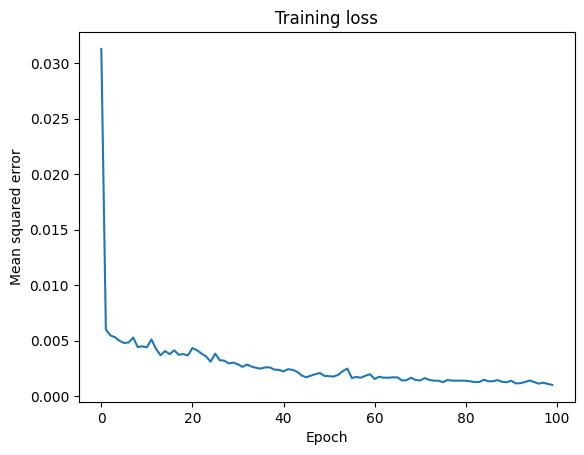

In [27]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('Training loss')
plt.show()

### Comparison of real training data and predicted train data

In [28]:
# Prediction
predicted_train_price = model.predict(X_train)

# Plot results
plt.plot(train['Date'], train['Open'])
plt.title("Google stock price from 2012 to 2016")
plt.xlabel("Date")
plt.ylabel("Price (Open)")
plt.show()

38/38 [==============================] - 6s 46ms/step


In [29]:
print(len(predicted_train_price))
print(len(train['Date']))

1198
1258


### Evaluation of test data (January 2017)

In [38]:
# Prepare test data
open_test = test['Open'].values

# Concatenate train and test set
dataset_total = pd.concat([train['Open'], test['Open']], axis = 0)

# For every day of January 2017 get the price of last 60 days
inputs = dataset_total[len(dataset_total) - len(test) - 60: ].values

# Reshape inputs
inputs = inputs.reshape(-1, 1)

# Scale data
inputs = scaler.transform(inputs).flatten()

# Prepare X_test
X_test = []
for i in range(60, len(inputs)):
  X_test.append(inputs[i-60:i])

X_test = np.array(X_test)

# Reshape X_test to match model dimensions
X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], 1))


In [39]:
# Predict results
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 109ms/step


In [40]:
# Apply inverse scaling
predicted_stock_price = scaler.inverse_transform(y_pred)

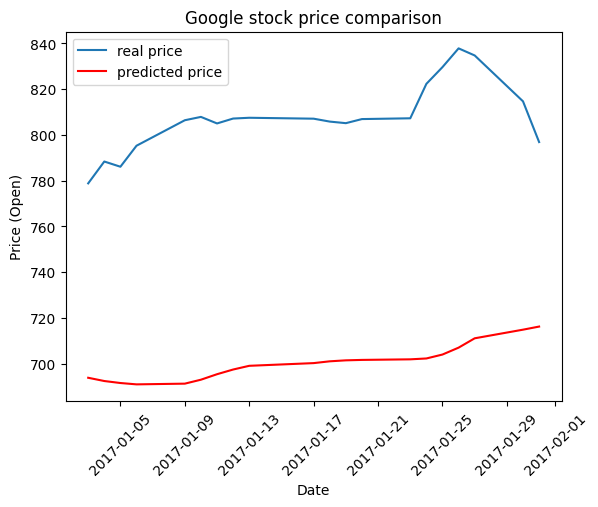

In [43]:
### Visualizing final result (predicted vs real price)
plt.plot(test['Date'], test['Open'], label = 'real price')
plt.plot(test['Date'], predicted_stock_price, label = 'predicted price', color = 'red')
plt.title("Google stock price comparison")
plt.xlabel("Date")
plt.ylabel("Price (Open)")
plt.xticks(rotation = 45)
plt.legend()
plt.show()